In [2]:
from PIL import Image     # Python Image Library
import numpy as np
import matplotlib.pyplot as plt
import sys
import math

In [36]:
!python -V

Python 3.8.8


### read images

In [3]:
images = []
images.append(Image.open('./Dataset/1.jpg'))
images.append(Image.open('./Dataset/2.jpg'))
images.append(Image.open('./Dataset/3.jpg'))
images.append(Image.open('./Dataset/4.png'))
images.append(Image.open('./Dataset/5.jpg'))

In [4]:
for i in range(len(images)):
    images[i] = images[i].convert('RGB')

C:\Users\user\Anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### contrast adjustment

In [5]:
def image_negative(image):
    image_array = np.array(image)
    negative = [255,255,255]-image_array
    output = Image.fromarray(negative.astype('uint8'))
    return output

In [6]:
def power_law_transform(image, gamma = 1, c = 1, image_is_array = False):
    image_array = np.array(image) if not image_is_array else image
    power_law = lambda p: 255*(c*(p/255)**gamma)
    output_array = power_law(image_array).astype('uint8')
    output = Image.fromarray(output_array) if not image_is_array else output_array
    return output

In [7]:
def plotBar(x,y,title=None):
    plt.bar(x,y)
    plt.title(title)
    plt.show()
    
def histogram_equalization(image, plot_bar = False):
    if image.mode != 'L':
        print('Input is not gray-scale image')
        return
    else:
        image_array = np.array(image)
        height, width =image_array.shape
        
        counts = np.zeros(256)
        for i in range(height):
            for j in range(width):
                counts[image_array[i,j]]+=1
        
        pdf = counts/image_array.size
        cdf = np.cumsum(pdf)
        image_array = 255*cdf[image_array] # (L-1)*cdf
        
        output = Image.fromarray(image_array.astype('uint8'))
        
        if plot_bar:
            plotBar(range(256),pdf,title = 'origin image histograms pdf')
            plotBar(range(256),cdf,title = 'origin image histograms cdf')
            unique, counts = np.unique(image_array, return_counts=True)
            plotBar(unique,counts/image_array.size, title = 'output image histograms pdf')
        
    return output

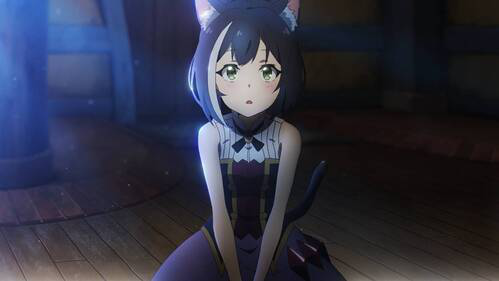

In [35]:
images[0]

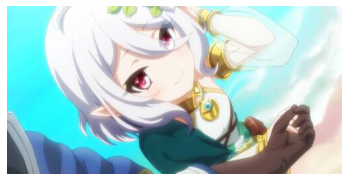

In [13]:
plt.imshow(images[1])
plt.axis('off')
plt.show()

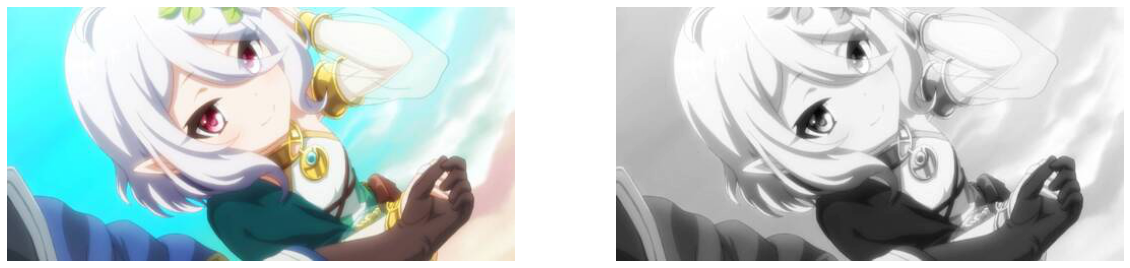

In [22]:
plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.imshow(images[1])
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(images[1].convert('L'),cmap='gray')
plt.axis('off')

plt.show()

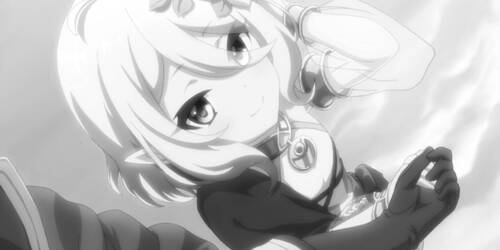

In [19]:
images[1].convert('L')

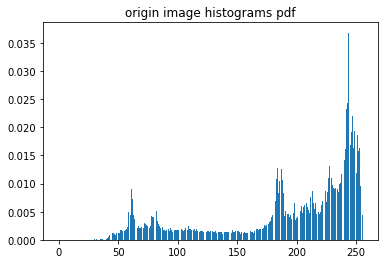

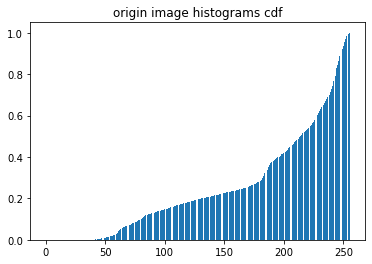

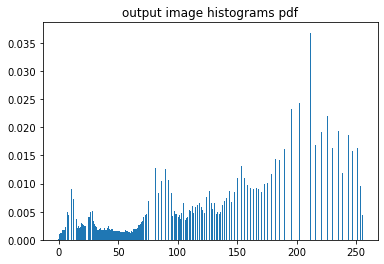

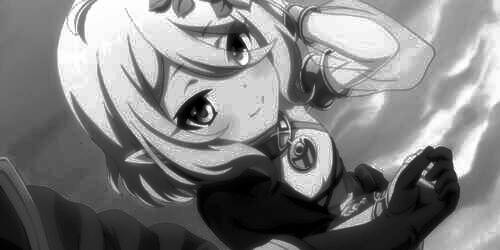

In [16]:
histogram_equalization(images[1].convert('L'), plot_bar=True)

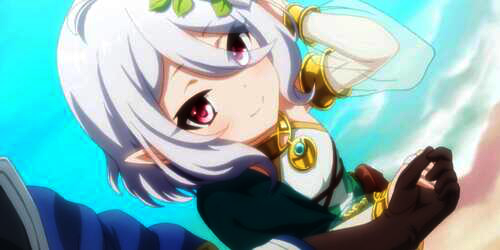

In [18]:
power_law_transform(images[1], gamma = 2)

### color correction

In [11]:
def color_correction_3D(image, gamma = [1,1,1], c = [1,1,1]):
    image_array = np.array(image)
    output_array = np.zeros_like(image_array)
    height, width, channel = image_array.shape
    for i in range(channel):
        output_array[:,:,i] = power_law_transform(image_array[:,:,i], gamma[i], c[i], image_is_array = True)
    output = Image.fromarray(output_array)
    return output

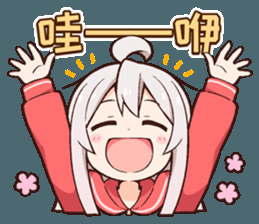

In [13]:
images[3]

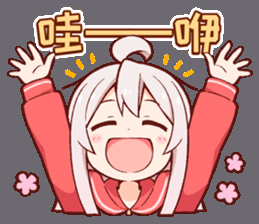

In [14]:
color_correction_3D(images[3], gamma = [0.7,1,1], c = [1,1,1])

### noise reduction

In [24]:
class Filter:
    def __init__(self, array = None, is_statistics = False, statistics = '', size = None):
        self.array = array
        self.is_statistics = is_statistics
        self.statistics = statistics
        self.shape = self.array.shape if size == None else size
        
    def __str__(self): 
        if not self.is_statistics: print(self.array)
        return str(self.shape) + ( ' Spatial Filter' if not self.is_statistics else 'Statistic Filter' )


In [25]:
Identity_Filter = Filter(np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]))
Top_Sobel_Filter = Filter(np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]))
Left_Sobel_Filter = Filter(np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]))
Bottom_Sobel_Filter = Filter(np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]]))
Right_Sobel_Filter = Filter(np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]))
Laplacian_Filter = Filter(np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]))
Sharpen_Filter = Filter(np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
Outline_Filter = Filter(np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]))

def Averaging_Filter(size = (3,3)):
    return Filter(np.full(size,1)/(size[0]*size[1]))

def Gaussian_Smooting_Filter(size = (3,3), sigma = 1):
    output = np.zeros(size)
    h = (size[0]-1)/2
    w = (size[1]-1)/2
    for i in range(size[0]):
        for j in range(size[1]):
            output[i,j] = (1/(2*math.pi*(sigma**2)))*math.exp(-((i-h)**2+(j-w)**2)/(2*sigma**2))
    return Filter(output)

def Max_Filter(size = (3,3)):
    return Filter(is_statistics = True, statistics = 'Max', size = size)

def Min_Filter(size = (3,3)):
    return Filter(is_statistics = True, statistics = 'Min', size = size)

def Mean_Filter(size = (3,3)):
    return Filter(is_statistics = True, statistics = 'Mean', size = size)

def Medium_Filter(size = (3,3)):
    return Filter(is_statistics = True, statistics = 'Medium', size = size)

def Midpoint_Filter(size = (3,3)):
    return Filter(is_statistics = True, statistics = 'Midpoint', size = size)

def Adaptive_Filter(size = (3,3)):
    return Filter(is_statistics = True, statistics = 'Adaptive', size = size)

def Adaptive_Medium_Filter(size = (3,3)):
    return Filter(is_statistics = True, statistics = 'Adaptive Medium', size = size)

In [26]:
def add_noise(image, strength, mode):
    image_array = np.array(image)/255
    if mode == 'Gaussian':
        noise = np.random.normal(0, strength, image_array.shape)
    elif mode == 'Salt and Pepper':
        noise = np.random.choice([-2,0,2],image_array.shape[0:2], p = [strength/2, 1-strength, strength/2])
        if len(image_array.shape) == 3:
            noise = np.repeat(noise[:,:,np.newaxis], 3, axis=2)  
    output_array = image_array + noise
    output_array = np.clip(output_array, 0, 1)*255
    output = Image.fromarray(output_array.astype('uint8'))
    return output       

In [27]:
def convolution2D(image, kernal, zero_padding = True, image_is_array = False):
    if(not image_is_array and len(np.array(image).shape)!=2):
        print('this is for 2d image, your input image is ' + str(len(np.array(image).shape)) + 'd')
        return
    
    image_array = np.array(image) if not image_is_array else image
    if zero_padding:
        h = (kernal.shape[0]-1)//2
        w = (kernal.shape[1]-1)//2
        image_array = np.pad(image_array, ((h,h),(w,w)), 'constant')

    image_height, image_width = image_array.shape
    kernal_height, kernal_width = kernal.shape 
    output_array = np.zeros((image_height-kernal_height+1, image_width-kernal_width+1)).astype(int)
    noice_var = np.var(image_array)
    for x in range(image_height-kernal_height+1):
        for y in range(image_width-kernal_width+1):
            if not kernal.is_statistics:
                output_array[x,y] = np.sum(image_array[x:x+kernal_height,y:y+kernal_width]*kernal.array)
            else:
                if kernal.statistics == 'Max':
                    output_array[x,y] = np.max(image_array[x:x+kernal_height,y:y+kernal_width])
                elif kernal.statistics == 'Min':
                    output_array[x,y] = np.min(image_array[x:x+kernal_height,y:y+kernal_width])
                elif kernal.statistics == 'Medium':
                    output_array[x,y] = np.median(image_array[x:x+kernal_height,y:y+kernal_width])
                elif kernal.statistics == 'Mean':
                    output_array[x,y] = np.mean(image_array[x:x+kernal_height,y:y+kernal_width])
                elif kernal.statistics == 'Midpoint':
                    output_array[x,y] = (np.max(image_array[x:x+kernal_height,y:y+kernal_width]) +
                                         np.min(image_array[x:x+kernal_height,y:y+kernal_width])) / 2
                elif kernal.statistics == 'Adaptive':
                    g_xy = image_array[x+(kernal_height-1)//2,y+(kernal_width-1)//2]
                    local_var = np.var(image_array[x:x+kernal_height,y:y+kernal_width])
                    local_var = max(noice_var, local_var)
                    output_array[x,y] = g_xy-\
                    (noice_var/local_var)*(g_xy-np.mean(image_array[x:x+kernal_height,y:y+kernal_width]))
                elif kernal.statistics == 'Adaptive Medium':
                    kernal_height, kernal_width = kernal.shape
                    Z_xy = image_array[x+(kernal_height-1)//2,y+(kernal_width-1)//2]
                    i = 0 #increase
                    while(x-i>=0 and x+kernal_height+i<image_height \
                          and y-i>=0 and y+kernal_width+i<image_width):
                        z_min = np.min(image_array[x-i:x+kernal_height+i,y-i:y+kernal_width+i])
                        z_max = np.max(image_array[x-i:x+kernal_height+i,y-i:y+kernal_width+i])
                        z_med = np.median(image_array[x-i:x+kernal_height+i,y-i:y+kernal_width+i])
                        
                        if(not(z_min<z_med and z_med<z_max)):
                            i += 1
                        else: #Level b
                            if(z_min<Z_xy and Z_xy<z_max):
                                output_array[x,y] = Z_xy
                            else:
                                output_array[x,y] = z_med
                            break;
                    else:
                        output_array[x,y] = z_med
                

    output_array = np.clip(output_array, 0, 255)
    output = Image.fromarray(output_array.astype('uint8')) if not image_is_array else output_array
    return output

def convolution3D(image, kernal, image_is_array = False):
    if(not image_is_array and len(np.array(image).shape)!=3):
        print('this is for 3d image, your input image is ' + str(len(np.array(image).shape)) + 'd')
        return
    
    image_array = np.array(image) if not image_is_array else image
    output_array = np.zeros_like(image_array)
    
    image_height, image_width, image_channel = image_array.shape
    for i in range(image_channel):
        output_array[:,:,i] = convolution2D(image_array[:,:,i], kernal, image_is_array = True)
        
    output = Image.fromarray(output_array.astype('uint8')) if not image_is_array else output_array
    return output

In [28]:
def unsharp_masking(image, k):
    image_array = np.array(image)
    blurred_image_array = convolution3D(image_array, Averaging_Filter(size=3), image_is_array = True)
    unsharpen_mask = image_array-blurred_image_array
    sharpen_image_array = image_array + k * unsharpen_mask
    output = Image.fromarray(sharpen_image_array.astype('uint8'))
    return output

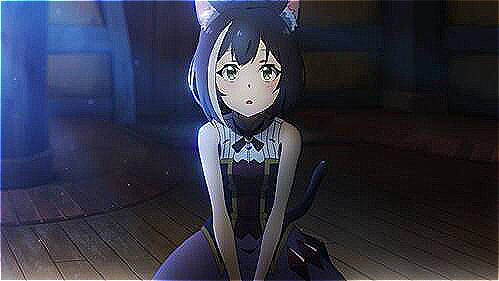

In [31]:
convolution3D(images[0], Sharpen_Filter)

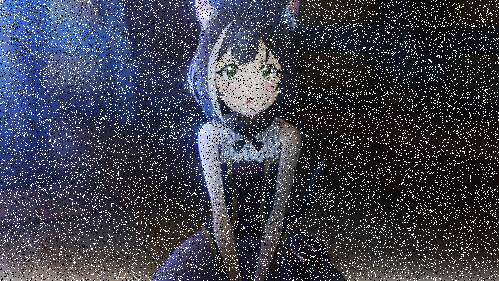

In [32]:
I = add_noise(images[0], strength = 0.2, mode='Salt and Pepper')
I

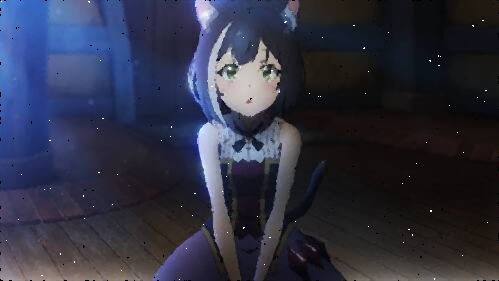

In [33]:
convolution3D(I, Medium_Filter(size = (3,3)))

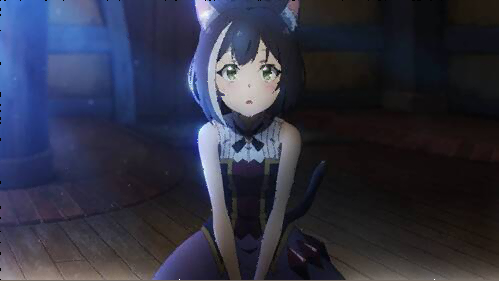

In [34]:
convolution3D(I, Adaptive_Medium_Filter(size = (3,3)))